In [7]:
# loading libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV as GridSearch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve,roc_curve


In [5]:
features_gaby = pd.read_csv('../features/features_gaby.csv')
features_gonza = pd.read_csv('../features/features_gonza.csv').drop(columns='Unnamed: 0')
features_ari = pd.read_csv('../features/features_ariel.csv')
features_mati = pd.read_csv('../features/features_frecuencia.csv')
labels_training_set = pd.read_csv('../dataset/labels_training_set.csv')
test_set = pd.read_csv('../dataset/trocafone_kaggle_test.csv')
features_gonza2 = pd.read_csv('../features/features_gonza2.csv')

In [6]:
#model_df = pd.merge(features_gaby, features_gonza, how='inner', on='person')
model_df = pd.merge(features_gaby, features_ari, how='inner', on='person')
model_df = pd.merge(model_df, features_gonza, how='inner', on='person')
model_df = pd.merge(model_df, features_gonza2, how='inner', on='person')
#model_df = pd.merge(model_df, features_mati, how='inner', on='person')
model_df.head()

,person,marca_favorita_apple,marca_favorita_asus,marca_favorita_lenovo,marca_favorita_lg,marca_favorita_motorola,marca_favorita_no tiene,marca_favorita_quantum,marca_favorita_samsung,marca_favorita_sony,...,generic listing,searched products,viewed product,visited site,completa_flujo,cantidad_lead_y,favorite_device_Computer,favorite_device_Smartphone,favorite_device_Tablet,favorite_device_Unknown
0,0008ed71,1,0,0,0,0,0,0,0,0,...,1.0,NaN,NaN,2.0,False,NaN,1,0,0,0
1,00091926,1,0,0,0,0,0,0,0,0,...,NaN,NaN,372.0,34.0,False,NaN,1,0,0,0
2,00091a7a,1,0,0,0,0,0,0,0,0,...,NaN,NaN,3.0,1.0,False,NaN,0,1,0,0
3,000ba417,0,0,0,0,0,0,0,1,0,...,14.0,NaN,153.0,6.0,False,NaN,1,0,0,0
4,000c79fe,1,0,0,0,0,0,0,0,0,...,1.0,9.0,3.0,1.0,False,NaN,0,1,0,0


In [71]:
model_df.fillna(value=0, inplace=True)
model_df['most_viewed_sku'] = model_df['most_viewed_sku'].astype('category')
model_df['favorite_device_Computer'] = model_df['favorite_device_Computer'].astype('category')
training_set = pd.merge(model_df, labels_training_set, how='inner', on='person')
test_set = pd.merge(model_df, test_set, how='inner', on='person')
#training_set.drop(columns= 'Unnamed: 0', inplace=True)

In [72]:
#training_set = training_set.drop(((training_set['label'] == 1) & (training_set['visited site'] == 0)).index)
#df = df.drop(df[(df.score < 50) & (df.score > 20)].index)


training_set = training_set.drop(training_set[(training_set.label == 1) & (training_set['visited site'] == 0)].index)

In [73]:
features_ari.columns

Index([u'Unnamed: 0', u'person', u'cant_accesos_southeast',
       u'cant_accesos_northeast', u'cant_accesos_south',
       u'cant_accesos_center_west', u'cant_accesos_north', u'time_first_event',
       u'time_last_event', u'how_long_ago_was_first_event',
       ...
       u'interest_last_142_days', u'interest_last_143_days',
       u'interest_last_144_days', u'interest_last_145_days',
       u'interest_last_146_days', u'interest_last_147_days',
       u'interest_last_148_days', u'interest_last_149_days',
       u'interest_last_150_days', u'interest_last_151_days'],
      dtype='object', length=190)

In [74]:
compradores = training_set.loc[training_set['label'] == 1]
no_compradores = training_set.loc[training_set['label'] == 0]

In [75]:
features = ['cant_total_eventos', #f1
            #'marca_favorita_apple',#f2
            'mean_events_per_day',#f3
            #'has_converted_before',#f4
            #'most_viewed_sku',#f5
            #'most_viewed_color_Preto',#f6
            #'most_viewed_color_Branco',#f7
            #'most_viewed_color_Dourado', #f8
            #'region_brasil_Sao Paulo',#f9
            #'region_brasil_Unknown',#f10
            #'region_brasil_Minas Gerais',#f11
            #'marca_favorita_samsung',#f12
            #'cant_ev_noche',#f13
            #'cant_ev_manana',#f14
            #'cant_ev_tarde',#f15
            #'cant_ev_madrugada',#f16
            #'cant_buenos',#f17
            #'cant_muy_buenos',#f18
            #'cant_excelentes',#f19
            #'nivel_de_actividad_Muy Bajo',#f20
            #'nivel_de_actividad_Muy Alto',#f21
            'nivel_de_actividad_Bajo',#f22
            'nivel_de_actividad_Medio',#f23
            'nivel_de_actividad_Alto',#f24
            #'favorite_device_Smartphone',#f25
            'favorite_device_Computer',#f26
            'cantidad_checkouts',#f27
            'cantidad_conversions',#f28
            'tasa_cc',
            'viewed product',
            #'cantidad_lead',
            #'searched products',
            #'first_and_last_event_distance_in_days',
            'month_moda',
            #'dias_distintos_con_eventos',
            #'eventos_totales_generados'
            #'completa_flujo'
            #'cant_modelo_iphone',
            #'cant_modelo_samsung',
            #'cant_modelo_motorola',
            #'cant_modelo_otro',
            #'porcentaje_modelo_iphone', 
            #'porcentaje_modelo_samsung',
            #'porcentaje_modelo_motorola', 
            #'porcentaje_modelo_otro',
            #'modelo_moda',
            'interest_last_151_days',
            'interest_last_4_days',
            'interest_last_6_days',
            'interest_last_8_days',
            'interest_last_10_days',
            'interest_last_12_days',
            'interest_last_14_days',
            'interest_last_16_days',
            'interest_last_18_days',
            'interest_last_20_days',
            'interest_last_22_days',
            'interest_last_24_days',
            'interest_last_26_days',
            'interest_last_28_days',
            'interest_last_30_days'
           ]

In [76]:
x = np.array(training_set[features])
y = np.array(training_set['label'])
z = np.array(test_set[features])
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20)

In [77]:
def modelfit(alg):
    alg.fit(X_train, y_train, eval_metric='aucpr')
    pred = (alg.predict_proba(X_test)[:,1])
    accuracy = accuracy_score(y_test, pred.round(), normalize=False)
    pred_proba = pred
    print("Accuracy: ", accuracy / float(pred.size))

    for i in xrange(0,pred.size):
        if (pred[i] >= 0.5):
            pred[i] = 1
        else: 
            pred[i] = 0

    print('---Classification Report---')
    print(classification_report(y_test,pred))
    print('AUROC :' + str(roc_auc_score(y_test, pred_proba)))
    
    
    

In [37]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=18,
 seed=27)
modelfit(xgb1)

('Accuracy: ', 0.919629057187017)
---Classification Report---
             precision    recall  f1-score   support

          0       0.96      0.95      0.96      3708
          1       0.18      0.22      0.20       174

avg / total       0.93      0.92      0.92      3882

AUROC :0.5882016516013837


In [11]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearch(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=18, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

NameError: name 'X_train' is not defined

In [88]:
param_test2 = {
    'max_depth':[1,2,3,4],
    'min_child_weight':[1,2,3,4]
}

gsearch2 = GridSearch(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=18, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.82451, std: 0.01062, params: {'max_depth': 1, 'min_child_weight': 1},
  mean: 0.82452, std: 0.01062, params: {'max_depth': 1, 'min_child_weight': 2},
  mean: 0.82468, std: 0.01060, params: {'max_depth': 1, 'min_child_weight': 3},
  mean: 0.82455, std: 0.01055, params: {'max_depth': 1, 'min_child_weight': 4},
  mean: 0.80235, std: 0.00895, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.80190, std: 0.00950, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.80569, std: 0.01098, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.80306, std: 0.00772, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.78432, std: 0.01053, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.78757, std: 0.01015, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.78781, std: 0.01354, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.78656, std: 0.00786, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.77456, std: 0.00870, params: {

In [87]:
param_test2b = {
    'min_child_weight':[4,5,6]
}

gsearch2 = GridSearch(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=25, seed=27), 
 param_grid = param_test2b, scoring='f1',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.22617, std: 0.01726, params: {'min_child_weight': 4},
  mean: 0.22624, std: 0.01454, params: {'min_child_weight': 5},
  mean: 0.22535, std: 0.01492, params: {'min_child_weight': 6}],
 {'min_child_weight': 5},
 0.2262385879618499)

In [89]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=1,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=18,
 seed=27)
modelfit(xgb1)

('Accuracy: ', 0.7733127253992788)
---Classification Report---
             precision    recall  f1-score   support

          0       0.98      0.78      0.87      3696
          1       0.14      0.74      0.24       186

avg / total       0.94      0.77      0.84      3882

AUROC :0.755860738723642


In [90]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearch(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=1,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=18,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.83645, std: 0.00961, params: {'gamma': 0.0},
  mean: 0.83645, std: 0.00961, params: {'gamma': 0.1},
  mean: 0.83645, std: 0.00961, params: {'gamma': 0.2},
  mean: 0.83645, std: 0.00961, params: {'gamma': 0.3},
  mean: 0.83645, std: 0.00961, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.8364477617947672)

In [30]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=18,
 seed=27)
modelfit(xgb1)

('Accuracy: ', 0.7828998197270152)
---Classification Report---
             precision    recall  f1-score   support

          0       0.98      0.78      0.87      3693
          1       0.15      0.75      0.25       190

avg / total       0.94      0.78      0.84      3883

AUROC :0.7660481422891103


In [91]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearch(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=1,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=18,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83639, std: 0.00932, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.83579, std: 0.00941, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.83635, std: 0.00936, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.83705, std: 0.00907, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.83666, std: 0.00955, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.83574, std: 0.00950, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.83643, std: 0.00947, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.83664, std: 0.00893, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.83630, std: 0.00966, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.83568, std: 0.01002, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.83645, std: 0.00961, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.83670, std: 0.00903, params: {'subsample': 0.9, 'colsample_bytree'

In [33]:
param_test5 = {
    'subsample':[i/100.0 for i in range(70,90,5)],
    'colsample_bytree':[i/100.0 for i in range(40,70,5)]
}

gsearch5 = GridSearch(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=18,seed=27), 
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

/home/gonzalodiz/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83225, std: 0.00973, params: {'subsample': 0.7, 'colsample_bytree': 0.4},
  mean: 0.83087, std: 0.00947, params: {'subsample': 0.75, 'colsample_bytree': 0.4},
  mean: 0.83131, std: 0.00947, params: {'subsample': 0.8, 'colsample_bytree': 0.4},
  mean: 0.83110, std: 0.00865, params: {'subsample': 0.85, 'colsample_bytree': 0.4},
  mean: 0.83225, std: 0.00973, params: {'subsample': 0.7, 'colsample_bytree': 0.45},
  mean: 0.83087, std: 0.00947, params: {'subsample': 0.75, 'colsample_bytree': 0.45},
  mean: 0.83131, std: 0.00947, params: {'subsample': 0.8, 'colsample_bytree': 0.45},
  mean: 0.83110, std: 0.00865, params: {'subsample': 0.85, 'colsample_bytree': 0.45},
  mean: 0.83127, std: 0.01021, params: {'subsample': 0.7, 'colsample_bytree': 0.5},
  mean: 0.83117, std: 0.01012, params: {'subsample': 0.75, 'colsample_bytree': 0.5},
  mean: 0.83172, std: 0.01065, params: {'subsample': 0.8, 'colsample_bytree': 0.5},
  mean: 0.83273, std: 0.00992, params: {'subsample': 0.85, 'colsamp

In [215]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=18,
 seed=27)
modelfit(xgb1)

('Accuracy: ', 0.8042750450682462)
---Classification Report---
             precision    recall  f1-score   support

          0       0.98      0.81      0.89      3685
          1       0.15      0.62      0.24       198

avg / total       0.93      0.80      0.85      3883

AUROC :0.7176616915422885


In [42]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearch(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.9,
objective= 'binary:logistic', nthread=4, scale_pos_weight=18,seed=27), 
param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train,y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

/home/gonzalodiz/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.82993, std: 0.00955, params: {'reg_alpha': 1e-05},
  mean: 0.83033, std: 0.00974, params: {'reg_alpha': 0.01},
  mean: 0.82997, std: 0.00976, params: {'reg_alpha': 0.1},
  mean: 0.82967, std: 0.00999, params: {'reg_alpha': 1},
  mean: 0.83323, std: 0.00994, params: {'reg_alpha': 100}],
 {'reg_alpha': 100},
 0.8332269153677311)

In [216]:
param_test7 = {
    'reg_alpha':[100,120]
}

gsearch7 = GridSearch(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.9,
objective= 'binary:logistic', nthread=4, scale_pos_weight=18,seed=27), 
param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train,y_train)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch6.best_score_

([mean: 0.84056, std: 0.00119, params: {'reg_alpha': 100},
  mean: 0.84011, std: 0.00123, params: {'reg_alpha': 120}],
 {'reg_alpha': 100},
 0.8332269153677311)

In [92]:
param_test8 = {
    'learning_rate':[0, 0.001, 0.01, 0.1, 0.2]
}

gsearch8 = GridSearch(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=1,
min_child_weight=3, gamma=0, subsample=0.9, colsample_bytree=0.6, reg_alpha=100,
objective= 'binary:logistic', nthread=4, scale_pos_weight=18,seed=27), 
param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch8.fit(X_train,y_train)
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.50000, std: 0.00000, params: {'learning_rate': 0},
  mean: 0.82104, std: 0.01072, params: {'learning_rate': 0.001},
  mean: 0.82240, std: 0.01120, params: {'learning_rate': 0.01},
  mean: 0.83643, std: 0.01012, params: {'learning_rate': 0.1},
  mean: 0.83656, std: 0.00934, params: {'learning_rate': 0.2}],
 {'learning_rate': 0.2},
 0.8365580274280002)

In [94]:
param_test8 = {
    'learning_rate':[0, 0.0001, 0.001, 0.3, 0.4]
}

gsearch8 = GridSearch(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=1,
min_child_weight=3, gamma=0, subsample=0.6, colsample_bytree=0.9,
objective= 'binary:logistic', nthread=4, scale_pos_weight=18,seed=27), 
param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch8.fit(X_train,y_train)
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.50000, std: 0.00000, params: {'learning_rate': 0},
  mean: 0.76101, std: 0.01939, params: {'learning_rate': 0.0001},
  mean: 0.76101, std: 0.01939, params: {'learning_rate': 0.001},
  mean: 0.83049, std: 0.01162, params: {'learning_rate': 0.3},
  mean: 0.82811, std: 0.00950, params: {'learning_rate': 0.4}],
 {'learning_rate': 0.3},
 0.8304906223022327)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20)

In [79]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=1,
 min_child_weight=3,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.9,
 reg_alpha=100,
 objective= 'binary:logistic',
 nthread=-1,
 scale_pos_weight=18,
 seed=27)
modelfit(xgb1)

('Accuracy: ', 0.7691911385883565)
---Classification Report---
             precision    recall  f1-score   support

          0       0.98      0.77      0.86      3674
          1       0.15      0.72      0.25       208

avg / total       0.94      0.77      0.83      3882

AUROC :0.7465322850801893


In [81]:
importances = pd.DataFrame({'feature':features,'importance':np.round(xgb1.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

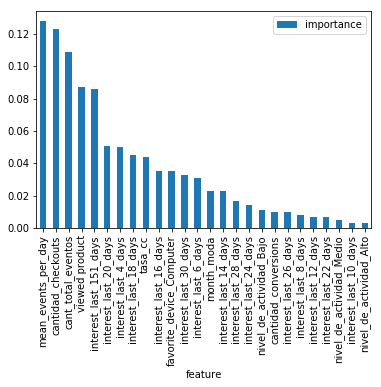

In [82]:
importances.plot.bar()

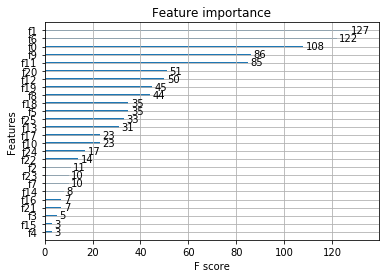

In [84]:
plot_importance(xgb1)

In [88]:
xgb1.fit(x,y, eval_metric='aucpr')
pred = (xgb1.predict_proba(z)[:,1])

In [89]:
persons = test_set['person']
submit = pd.DataFrame({'label': pred, 'person': persons})
submit = submit[['person', 'label']]
submit.to_csv('../submits/xgboost.csv', index=False)
no_conversiones = submit.loc[submit['label'] < 0.5]['label'].count()
print 'Cantidad de no conversiones: ' + str(no_conversiones)

conversiones = submit.loc[submit['label'] >= 0.5]['label'].count()
print 'Cantidad de conversiones: ' + str(conversiones)

Cantidad de no conversiones: 14304
Cantidad de conversiones: 5111


In [87]:
submit['label'].mean()

0.3287714421749115

## RANDOM FOREST

In [425]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100, )
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [426]:
pred = clf.predict_proba(X_test)[:,1]

In [427]:
cantidad_unos = 0
cantidad_ceros = 0
for i in xrange(0,pred.size):
        if (pred[i] >= 0.5):
            pred[i] = 1
            cantidad_unos += 1
        else: 
            pred[i] = 0
            cantidad_ceros += 1
            
print (accuracy_score(y_test, pred, ))          
print (classification_report(y_test, pred))
print ('Cantidad de 0 :' + str(cantidad_ceros))
print ('Cantidad de 1 :' + str(cantidad_unos))

0.9430852433685295
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3687
          1       0.10      0.02      0.03       196

avg / total       0.91      0.94      0.92      3883

Cantidad de 0 :3852
Cantidad de 1 :31


In [428]:
pred

array([0., 0., 0., ..., 0., 0., 0.])

In [429]:
roc_auc_score(y_test,pred)

0.5038559361905869

In [160]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
class_weight=[{0:1, 1:25}]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weight
              }
print(random_grid)

{'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'class_weight': [{0: 1, 1: 25}]}


In [166]:
crf = RandomForestClassifier()
crf_random = RandomizedSearchCV(estimator= crf, param_distributions= random_grid,
                               n_iter = 100, cv = 3, verbose = 2, random_state=42, n_jobs=-1, scoring='roc_auc')

In [167]:
crf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=400, min_samples_split=5, max_features=sqrt, max_depth=30, class_weight={0: 1, 1: 25} 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=400, min_samples_split=5, max_features=sqrt, max_depth=30, class_weight={0: 1, 1: 25} 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=400, min_samples_split=5, max_features=sqrt, max_depth=30, class_weight={0: 1, 1: 25} 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=2000, min_samples_split=5, max_features=sqrt, max_depth=10, class_weight={0: 1, 1: 25} 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=2000, min_samples_split=5, max_features=sqrt, max_depth=10, class_weight={0: 1, 1: 25} 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=2000, min_samples_split=5, max_features=sqrt, max_depth=10, class_weight={0: 1, 1: 25} 
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=1200, min_samples_split=5, max_fe

[CV] bootstrap=True, min_samples_leaf=4, n_estimators=400, min_samples_split=10, max_features=auto, max_depth=70, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=400, min_samples_split=10, max_features=auto, max_depth=70, class_weight={0: 1, 1: 25}, total=   5.7s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=400, min_samples_split=10, max_features=auto, max_depth=70, class_weight={0: 1, 1: 25} 


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min


[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=400, min_samples_split=10, max_features=auto, max_depth=70, class_weight={0: 1, 1: 25}, total=   5.6s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=800, min_samples_split=5, max_features=sqrt, max_depth=90, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=400, min_samples_split=10, max_features=auto, max_depth=70, class_weight={0: 1, 1: 25}, total=   5.7s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=800, min_samples_split=5, max_features=sqrt, max_depth=90, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=1000, min_samples_split=2, max_features=auto, max_depth=50, class_weight={0: 1, 1: 25}, total=  21.7s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=800, min_samples_split=5, max_features=sqrt, max_depth=90, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=1000, min_samples_split=2, max_features=auto, 

[CV] bootstrap=False, min_samples_leaf=1, n_estimators=1800, min_samples_split=10, max_features=sqrt, max_depth=30, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=600, min_samples_split=5, max_features=auto, max_depth=80, class_weight={0: 1, 1: 25}, total=   9.1s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=1800, min_samples_split=10, max_features=sqrt, max_depth=30, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=1800, min_samples_split=2, max_features=auto, max_depth=50, class_weight={0: 1, 1: 25}, total=  36.1s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=1800, min_samples_split=10, max_features=sqrt, max_depth=30, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=600, min_samples_split=5, max_features=auto, max_depth=80, class_weight={0: 1, 1: 25}, total=   9.2s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=1600, min_samples_split=5, max_features=sqr

[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=1000, min_samples_split=5, max_features=sqrt, max_depth=20, class_weight={0: 1, 1: 25}, total=  14.9s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=1200, min_samples_split=2, max_features=sqrt, max_depth=20, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=1400, min_samples_split=2, max_features=auto, max_depth=40, class_weight={0: 1, 1: 25}, total=  29.6s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=1200, min_samples_split=2, max_features=sqrt, max_depth=20, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=1400, min_samples_split=2, max_features=auto, max_depth=40, class_weight={0: 1, 1: 25}, total=  30.2s
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=1200, min_samples_split=10, max_features=sqrt, max_depth=20, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=1400, min_samples_split=2, max_features=aut

[CV] bootstrap=True, min_samples_leaf=2, n_estimators=800, min_samples_split=5, max_features=auto, max_depth=None, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=1200, min_samples_split=5, max_features=sqrt, max_depth=20, class_weight={0: 1, 1: 25}, total=  17.7s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=800, min_samples_split=5, max_features=auto, max_depth=None, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1800, min_samples_split=2, max_features=sqrt, max_depth=90, class_weight={0: 1, 1: 25}, total=  26.1s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=1000, min_samples_split=2, max_features=sqrt, max_depth=60, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=800, min_samples_split=2, max_features=auto, max_depth=100, class_weight={0: 1, 1: 25}, total=  12.6s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=1000, min_samples_split=2, max_features=sqrt, m

[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=400, min_samples_split=10, max_features=sqrt, max_depth=80, class_weight={0: 1, 1: 25}, total=   8.0s
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=400, min_samples_split=10, max_features=sqrt, max_depth=80, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=400, min_samples_split=10, max_features=sqrt, max_depth=80, class_weight={0: 1, 1: 25}, total=   7.9s
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=1200, min_samples_split=2, max_features=sqrt, max_depth=70, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=1000, min_samples_split=2, max_features=sqrt, max_depth=110, class_weight={0: 1, 1: 25}, total=  15.4s
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=1200, min_samples_split=2, max_features=sqrt, max_depth=70, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=1000, min_samples_split=2, max_features=sq

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.7min


[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=1200, min_samples_split=2, max_features=sqrt, max_depth=70, class_weight={0: 1, 1: 25}, total=  23.9s
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=2000, min_samples_split=10, max_features=auto, max_depth=50, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=1200, min_samples_split=2, max_features=sqrt, max_depth=70, class_weight={0: 1, 1: 25}, total=  23.4s
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=2000, min_samples_split=10, max_features=auto, max_depth=50, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=1200, min_samples_split=2, max_features=sqrt, max_depth=70, class_weight={0: 1, 1: 25}, total=  24.5s
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=1000, min_samples_split=10, max_features=auto, max_depth=50, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=2, n_estimators=600, min_samples_split=2, max_features

[CV] bootstrap=True, min_samples_leaf=1, n_estimators=200, min_samples_split=2, max_features=sqrt, max_depth=50, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=1400, min_samples_split=2, max_features=auto, max_depth=100, class_weight={0: 1, 1: 25}, total=  24.4s
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=200, min_samples_split=2, max_features=sqrt, max_depth=50, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=1400, min_samples_split=2, max_features=auto, max_depth=100, class_weight={0: 1, 1: 25}, total=  23.9s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=400, min_samples_split=2, max_features=sqrt, max_depth=10, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=200, min_samples_split=2, max_features=sqrt, max_depth=50, class_weight={0: 1, 1: 25}, total=   3.6s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=400, min_samples_split=2, max_features=sqrt, max_de

[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=1800, min_samples_split=2, max_features=auto, max_depth=10, class_weight={0: 1, 1: 25}, total=  31.2s
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=2000, min_samples_split=10, max_features=auto, max_depth=60, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=1400, min_samples_split=2, max_features=auto, max_depth=70, class_weight={0: 1, 1: 25}, total=  20.7s
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=1400, min_samples_split=2, max_features=sqrt, max_depth=80, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=1400, min_samples_split=2, max_features=auto, max_depth=70, class_weight={0: 1, 1: 25}, total=  21.0s
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=1400, min_samples_split=2, max_features=sqrt, max_depth=80, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=1000, min_samples_split=10, max_features=s

[CV] bootstrap=True, min_samples_leaf=2, n_estimators=1000, min_samples_split=5, max_features=sqrt, max_depth=10, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=1000, min_samples_split=5, max_features=sqrt, max_depth=10, class_weight={0: 1, 1: 25}, total=  13.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=200, min_samples_split=5, max_features=auto, max_depth=80, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=1000, min_samples_split=5, max_features=sqrt, max_depth=10, class_weight={0: 1, 1: 25}, total=  13.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=200, min_samples_split=5, max_features=auto, max_depth=80, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=1600, min_samples_split=10, max_features=sqrt, max_depth=None, class_weight={0: 1, 1: 25}, total=  24.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=200, min_samples_split=5, max_features=auto, max

[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=400, min_samples_split=5, max_features=sqrt, max_depth=100, class_weight={0: 1, 1: 25}, total=   6.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=800, min_samples_split=10, max_features=sqrt, max_depth=100, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=400, min_samples_split=5, max_features=sqrt, max_depth=100, class_weight={0: 1, 1: 25}, total=   6.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=800, min_samples_split=10, max_features=sqrt, max_depth=100, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=800, min_samples_split=5, max_features=sqrt, max_depth=70, class_weight={0: 1, 1: 25}, total=  16.0s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=800, min_samples_split=10, max_features=sqrt, max_depth=100, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=600, min_samples_split=10, max_features=sqrt

[CV] bootstrap=False, min_samples_leaf=4, n_estimators=200, min_samples_split=5, max_features=auto, max_depth=100, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=2, n_estimators=400, min_samples_split=10, max_features=auto, max_depth=40, class_weight={0: 1, 1: 25}, total=   8.3s
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=200, min_samples_split=5, max_features=auto, max_depth=100, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=200, min_samples_split=5, max_features=auto, max_depth=100, class_weight={0: 1, 1: 25}, total=   4.0s
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=200, min_samples_split=5, max_features=auto, max_depth=100, class_weight={0: 1, 1: 25} 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=200, min_samples_split=5, max_features=auto, max_depth=100, class_weight={0: 1, 1: 25}, total=   3.9s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=2000, min_samples_split=2, max_features=sqr

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.7min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'class_weight': [{0: 1, 1: 25}]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', 

In [168]:
crf_random.best_params_

#{'bootstrap': False,
# 'max_depth': 10,
# 'max_features': 'auto',
# 'min_samples_leaf': 4,
# 'min_samples_split': 5,
# 'n_estimators': 1800}

{'bootstrap': True,
 'class_weight': {0: 1, 1: 25},
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 400}

In [440]:
clf = RandomForestClassifier(n_estimators = 400, max_depth = 10,
                            max_features='sqrt',
                            min_samples_leaf=4,
                            min_samples_split=2,
                            bootstrap=True,
                            class_weight={0:1, 1:25}
                        )
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 25},
            criterion='gini', max_depth=10, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [441]:
pred = clf.predict_proba(X_test)[:,1]
cantidad_unos = 0
cantidad_ceros = 0
for i in xrange(0,pred.size):
        if (pred[i] >= 0.5):
            pred[i] = 1
            cantidad_unos += 1
        else: 
            pred[i] = 0
            cantidad_ceros += 1
            
print (accuracy_score(y_test, pred, ))          
print (classification_report(y_test, pred))
print ('Cantidad de 0 :' + str(cantidad_ceros))
print ('Cantidad de 1 :' + str(cantidad_unos))
print ('AUC ROC ' + str(roc_auc_score(y_test, pred)))


0.8328611898016998
             precision    recall  f1-score   support

          0       0.97      0.85      0.91      3687
          1       0.17      0.58      0.26       196

avg / total       0.93      0.83      0.87      3883

Cantidad de 0 :3202
Cantidad de 1 :681
AUC ROC 0.7139245445940785


In [435]:
clf.fit(x,y)
pred = (clf.predict_proba(z)[:,1])

In [433]:
persons = test_set['person']
submit = pd.DataFrame({'label': pred, 'person': persons})
submit = submit[['person', 'label']]
submit.to_csv('../submits/random_forest.csv', index=False)
no_conversiones = submit.loc[submit['label'] < 0.5]['label'].count()
print 'Cantidad de no conversiones: ' + str(no_conversiones)

conversiones = submit.loc[submit['label'] >= 0.5]['label'].count()
print 'Cantidad de conversiones: ' + str(conversiones)

Cantidad de no conversiones: 15535
Cantidad de conversiones: 3880


In [179]:
from sklearn.ensemble import VotingClassifier

In [288]:
classifiers = []
classifiers.append(('xgb',xgb1))
classifiers.append(('rf',clf))

In [289]:
vc = VotingClassifier(classifiers, voting='soft', n_jobs=-1,
                    weights=[20,1])

In [290]:
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1, min_child_weight=3, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='binary:logistic', random...mators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=[20, 1])

In [294]:
pred = vc.predict_proba(X_test)[:,1]

In [295]:
cantidad_unos = 0
cantidad_ceros = 0
for i in xrange(0,pred.size):
        if (pred[i] >= 0.5):
            pred[i] = 1
            cantidad_unos += 1
        else: 
            pred[i] = 0
            cantidad_ceros += 1
            
print (accuracy_score(y_test, pred, ))          
print (classification_report(y_test, pred))
print ('Cantidad de 0 :' + str(cantidad_ceros))
print ('Cantidad de 1 :' + str(cantidad_unos))
print ('AUC ROC ' + str(roc_auc_score(y_test, pred)))

0.730620654133402
             precision    recall  f1-score   support

          0       0.98      0.73      0.84      3684
          1       0.13      0.77      0.23       199

avg / total       0.94      0.73      0.81      3883

Cantidad de 0 :2730
Cantidad de 1 :1153
AUC ROC 0.7487000692932634


In [263]:
vc.fit(x,y)
pred = (vc.predict_proba(z)[:,1])

In [264]:
persons = test_set['person']
submit = pd.DataFrame({'label': pred, 'person': persons})
submit = submit[['person', 'label']]
submit.to_csv('../submits/vc_xgb_rf.csv', index=False)
no_conversiones = submit.loc[submit['label'] < 0.5]['label'].count()
print 'Cantidad de no conversiones: ' + str(no_conversiones)

conversiones = submit.loc[submit['label'] >= 0.5]['label'].count()
print 'Cantidad de conversiones: ' + str(conversiones)

Cantidad de no conversiones: 13210
Cantidad de conversiones: 6205
